# Completeness Test - 02.4
<hr>

- With the same procedure (grid sampling, grid in position + grid in flux)
- Correction of primary beam attenuation before injection
- Check completeness only until 1 PB

In [1]:
import os
import sys
import glob
import numpy as np
from astropy import units as u 
from astropy import coordinates
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Function to generate grid (position and scaled-flux)

In [2]:
def generate_sample(flux=1.02e-04, freq='241.23GHz', center=[65.8158364, -1.3425182], 
    PB=24.0, beam=0.2, imagesize=48.0, spacing=10, outputfile="sample.dat"):
    """
    Generate grid sample, with spacing parameter as input
    spacing is multiple of beamsize
    """

    PB_in_deg = PB/3600.0

    distance_between_source = spacing*beam

    grid = imagesize/(distance_between_source)

    number = (grid)**2

    print grid, number

    grid = int(grid)
    print "Grid size : ", grid, "x", grid, "\nTotal number of sample: ", grid*grid

    start  = [center[0] - imagesize/(2*3600) + 0.5*distance_between_source/3600.0, center[1] - imagesize/(2*3600) + 0.5*distance_between_source/3600.0]

    sample = []
    for i in range(grid):
        for j in range(grid):
            ra = start[0] + distance_between_source/3600. * i # degree
            dec = start[1] + distance_between_source/3600. * j

            # for easy transformation
            #c = coordinates.SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='fk5', equinox='J2000') 
            #pos = 'J2000 ' + str(c.to_string('hmsdms')) # unicode to str
            # Error: ancient astropy in ALMA Cluster!

            # flux scalling from PB
            theta_from_the_center = np.sqrt((ra - center[0])**2 + (dec - center[1])**2) # in degree
            scaled_flux = flux * np.exp(-np.log(2) * (2*theta_from_the_center/PB_in_deg)**2)

            #pos = 'J2000 ' + str(ra) + 'deg ' + str(dec) + 'deg'

            sample.append([ra, dec, scaled_flux])#, 'Jy', freq, 'point']) 

    # write to file
#     with open(outputfile, 'w') as ofile:
#         for item in sample:
#             for i in item:
#                 ofile.write("%s " % i)
#             ofile.write('\n')

    return np.array(sample) # ra, dec

In [3]:
# generate data sample only in the size of 1 PB (for analysis in here)
# B6 => 24 arcsec
sample = generate_sample(imagesize=24.0)

12.0 144.0
Grid size :  12 x 12 
Total number of sample:  144


### Overplot image and grid

In [4]:
multp = np.array([3, 3.5, 4.5, 5, 5.5, 6, 10, 100, 1000]) # contour of image
center = [65.8158364, -1.3425182]
PB = 24.0/3600.0

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Setting slices=[0, 0] [aplpy.core]


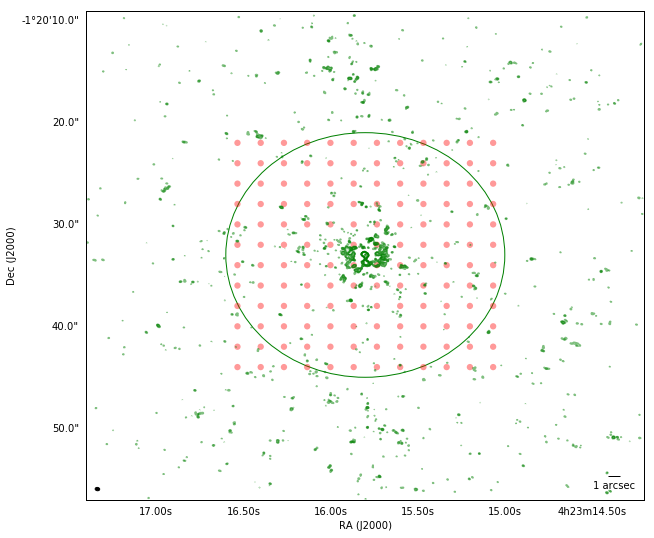

In [5]:
B6 = '../compareImage/images/J0423-0120_B6.fits'
rmsB6 = 3.4E-05

multp = np.array([2.5, 3, 3.5, 4.5, 5, 5.5, 6, 10, 100, 1000, 10000]) # sigma
lvlB6 = rmsB6*multp

fig = aplpy.FITSFigure(B6);
fig.add_beam()
fig.beam.set_color('black')
fig.add_scalebar(1 * u.arcsecond)
fig.scalebar.set_label('1 arcsec')
fig.scalebar.set_color("black")
fig.show_contour(B6, colors='green', levels=lvlB6, alpha=0.5);

fig.show_circles(center[0], center[1], PB/2.0, edgecolor='green')

## add marker for the position of fake source
fig.show_markers(sample[:,0], sample[:,1], edgecolor='none', facecolor='red', marker='o', s=40, alpha=0.4);

### Run the sextractor, read the catalogue, and *compare with injected-source

*detected or not

In [12]:
def read_sexofile(filename = "J0423-0120_B3.cat"):
    """Function to read sextractor output file."""
    pars = []
    # only get the header
    with open(filename, 'r') as ifile:
        for line in ifile:
            if line[0] == '#': 
                pars.append(line.split()[2])
                
    #print 'Col names: ', pars
    
    # get the data
    data = np.genfromtxt(filename, names=pars) # already in np array
    return data

In [8]:
# make a listname of all files generated from running (stat), and sextractor
dirname = './cttest01/'
sexofiles, fitsfiles, statfiles = [], [], []
fluxmin = 6.8e-05 # mimic the injection process
fluxmax = 3.4e-04
nflux   = 16
flux_injected = []
for flux in np.linspace(fluxmin, fluxmax, nflux):
    flux_injected.append(flux)
    sexofiles.append(dirname+'injected_flux_'+str(flux)+'.cont.cat')
    fitsfiles.append(dirname+'injected_flux_'+str(flux)+'.cont.fits')
    statfiles.append(dirname+'injected_flux_'+str(flux)+'.cont.stat')

In [9]:
dirtol = 0.1/3600 # arcsec to degree
print dirtol

2.77777777778e-05


In [10]:
def find_match(injected_source, extracted_source, dirtol=2.78E-05):
    """Brute force to match between injected source and extracted source
    dirtol [deg] is tolerance-distance to catagorize a source is match with the injected source 
    """
    list_of_match = []
    for s in injected_source:
        match = False
        ra, dec = s[0], s[1]
        list_ra, list_dec = extracted_source[:,0], extracted_source[:,1]
        
        # find distance from that list
        # using euclidean trigonometry [not a spherical]
        list_dist = np.sqrt((list_ra - ra)**2 + (list_dec - dec)**2)
        idx = np.where(list_dist <= dirtol) # index of match object
        
        if len(idx[0]) > 0:
            list_of_match.append(extracted_source[idx][0])
            if len(idx[0]) > 1:
                print "More than 1 source matched"
        
    return np.array(list_of_match)

### Run 'matching' , and overplot the detected dummy source

* red circle is injected source
* square is recovered source (using sextractor, threshold = 3sigma)
* completeness here is define as rasio between the number of recovered source and the number of injected source

Found:  8
Completeness:  5.55555555556 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  15
Completeness:  10.4166666667 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  19
Completeness:  13.1944444444 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  27
Completeness:  18.75 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  37
Completeness:  25.6944444444 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  44
Completeness:  30.5555555556 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  52
Completeness:  36.1111111111 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  58
Completeness:  40.2777777778 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  66
Completeness:  45.8333333333 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  73
Completeness:  50.6944444444 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  82
Completeness:  56.9444444444 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  86
Completeness:  59.7222222222 %
INFO: Setting slices=[0, 0] [aplpy.core]
Found:  92
Co

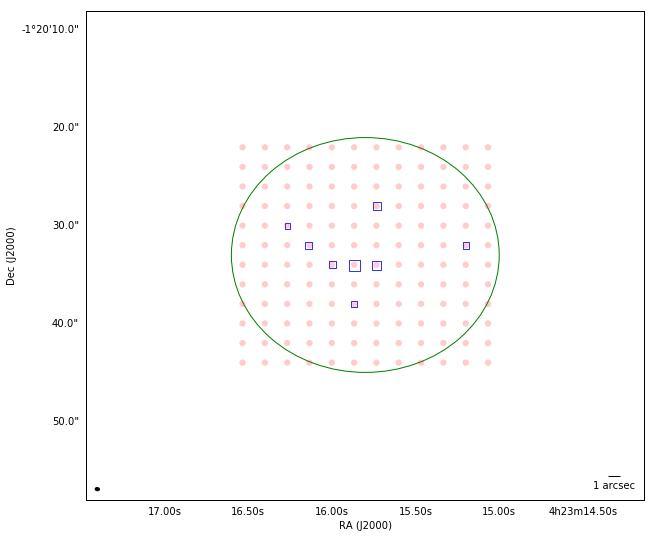

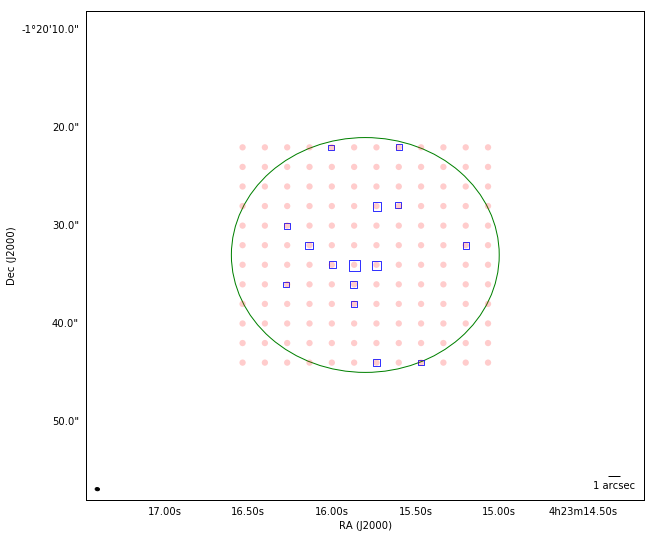

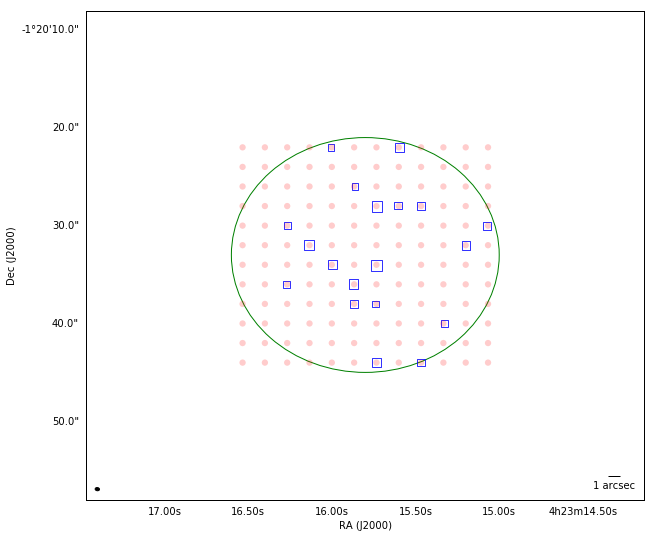

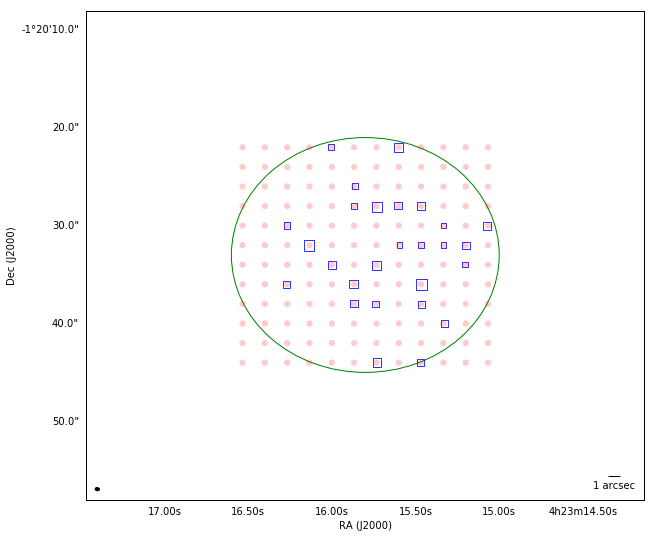

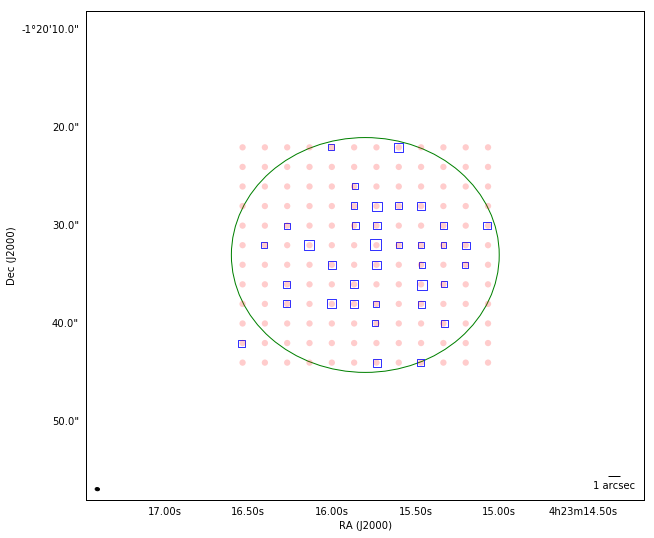

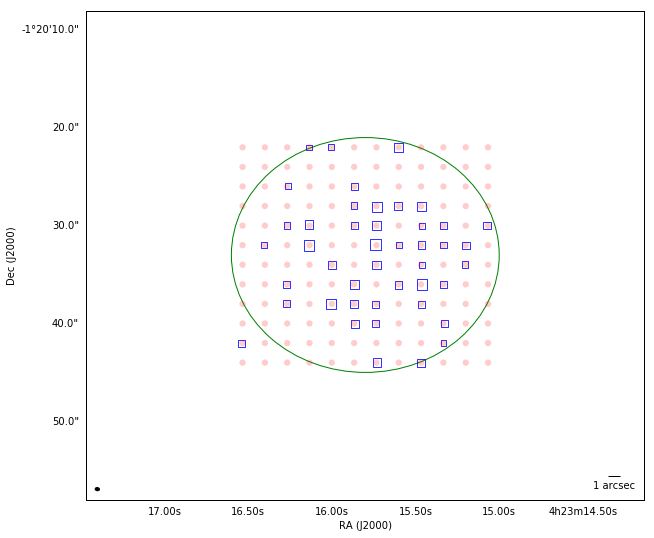

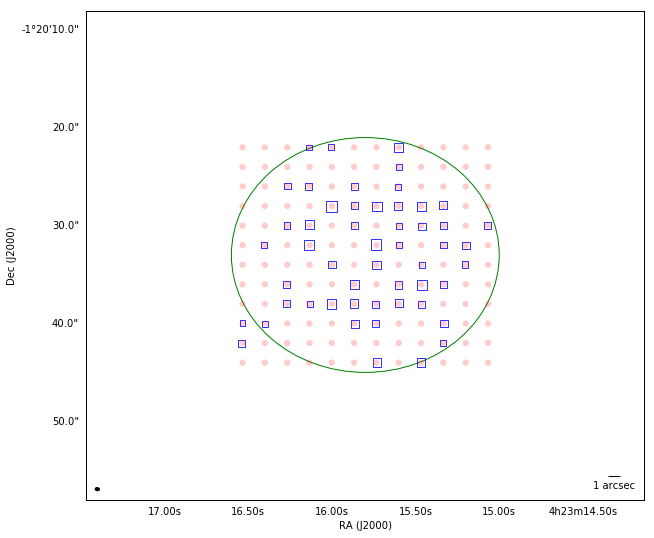

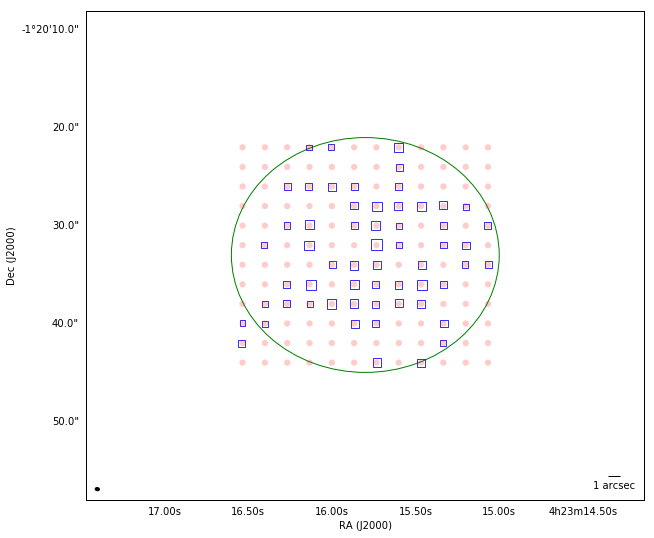

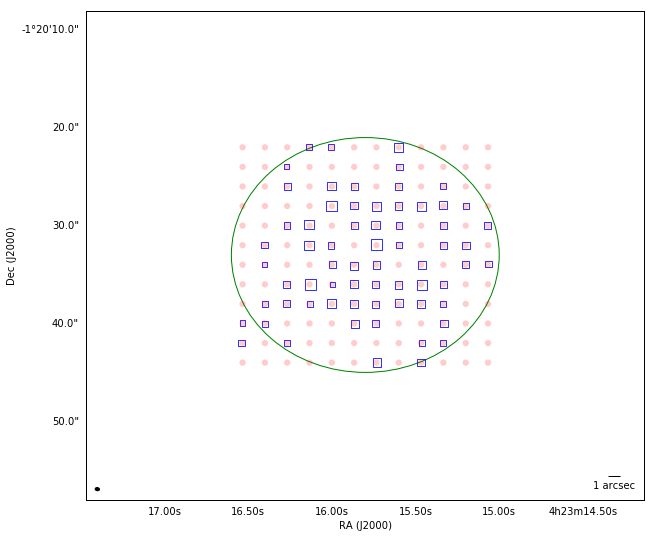

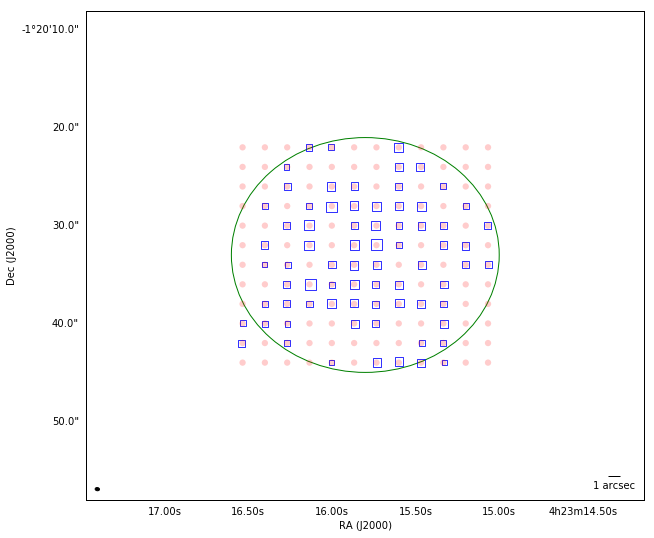

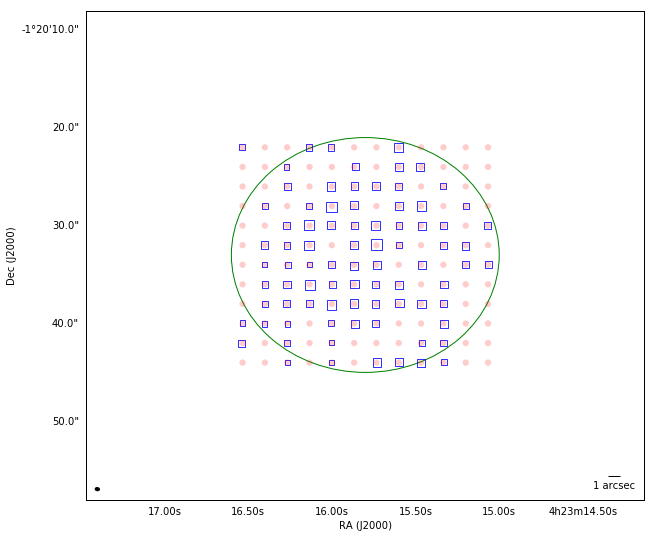

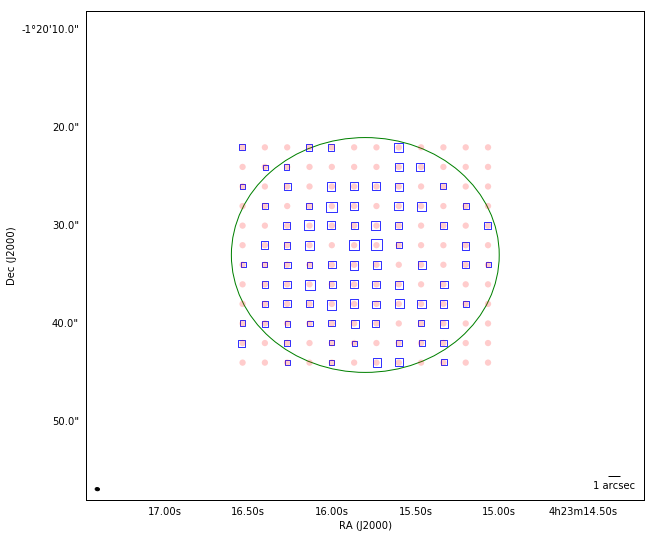

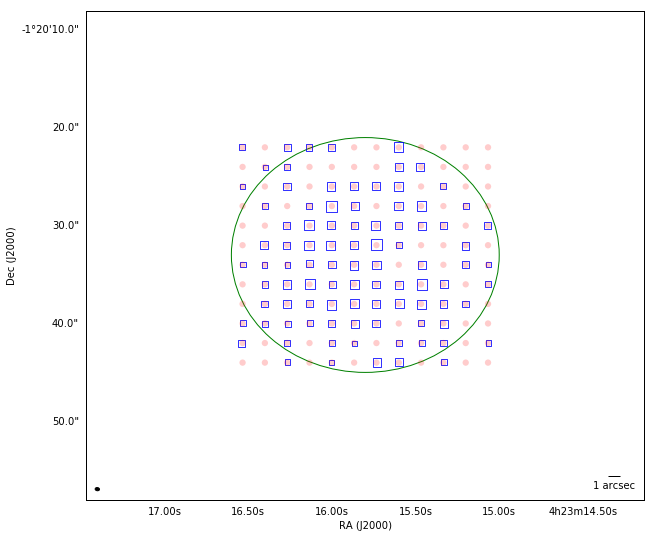

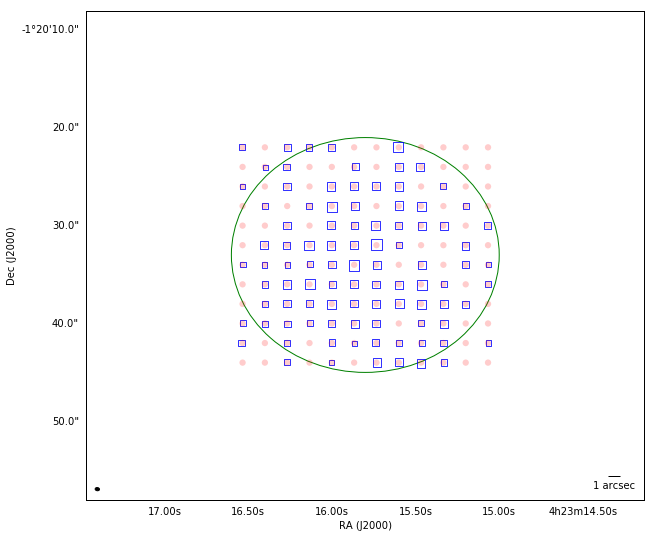

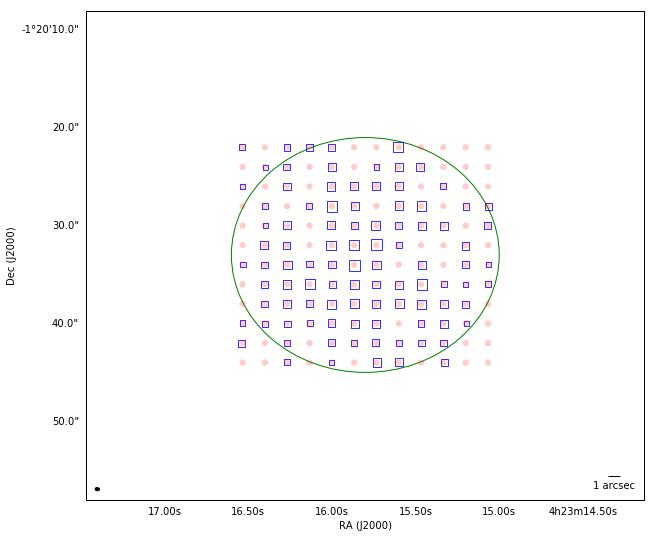

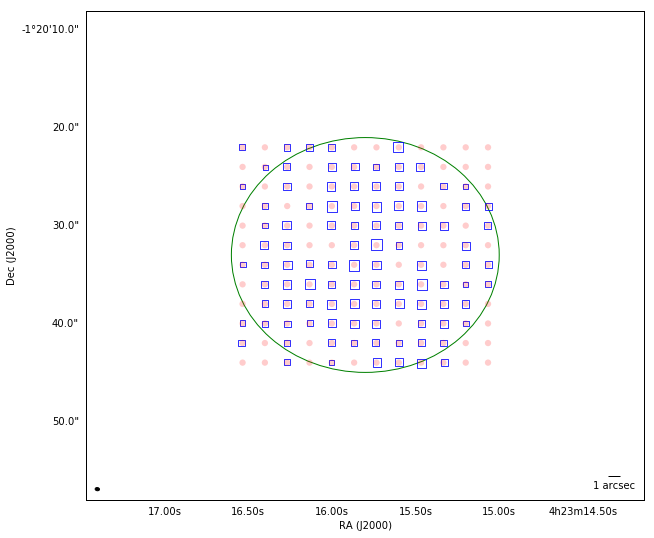

In [13]:
nsample = len(sample)
complete = []
for i, fitsfile in enumerate(fitsfiles):
    #fitsfile = './images/injected.ms.afterclean.withmask.cont.fits'
    #levels = 3.742764e-05*multp
    data = read_sexofile(sexofiles[i])
    extracted = np.array([data['ALPHA_J2000'], data['DELTA_J2000'], data['FLUX_BEST'], data['NUMBER'].astype('int')])
    ext = extracted.T
    res =  find_match(sample, ext, dirtol=2.78E-05)
    print "Found: ", len(res)
    comp = float(len(res))/nsample * 100
    print "Completeness: ", comp, "%"
    complete.append(comp)
    
    fig = aplpy.FITSFigure(fitsfile)

    # beam and scalebar
    fig.add_beam()
    fig.beam.set_color('black')
    fig.add_scalebar(1 * u.arcsecond)
    fig.scalebar.set_label('1 arcsec')
    fig.scalebar.set_color("black")

    # contour fits
    # fig.show_contour(fitsfile, colors='blue', levels=levels, alpha=0.6)

    # primary beam circle
    fig.show_circles(center[0], center[1], PB/2.0, edgecolor='green')

    #ra, dec, flux, label = selected_data_1 # uninjected
    #marker_size =  80 * flux/flux.max() + 10
    #fig.show_markers(ra, dec, edgecolor='red', facecolor='none', marker='o', s=marker_size, alpha=0.8)

    # matched
    ra, dec, flux, label = res[:,0], res[:,1], res[:,2], res[:,3]
    marker_size =  100 * flux/flux.max() + 20
    fig.show_markers(ra, dec, edgecolor='blue', facecolor='none', marker='s', s=marker_size, alpha=0.8)

    # injected source
    fig.show_markers(sample[:,0], sample[:,1], edgecolor='none', facecolor='red', marker='o', s=40, alpha=0.2);
    fig.save(fitsfile[:-5]+'.png')

### Plot the completeness

+ completeness-test usually shown as a plot of 'completeness' as function of 'SNR'
+ I use injected source flux as 'Signal'
+ And rms calculated in CASA from annulus-region as 'Noise'

In [14]:
stats = []
for statfile in statfiles:
    stats.append(np.loadtxt(statfile))

In [15]:
rms = []
for stat in stats:
    rms.append(stat[3])

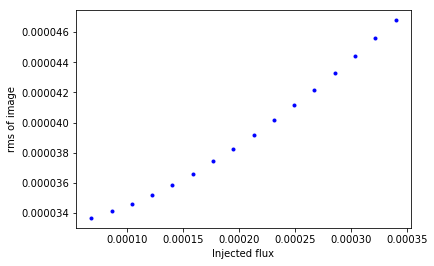

In [16]:
plt.plot(flux_injected, rms, 'b.')
plt.xlabel("Injected flux")
plt.ylabel("rms of image")

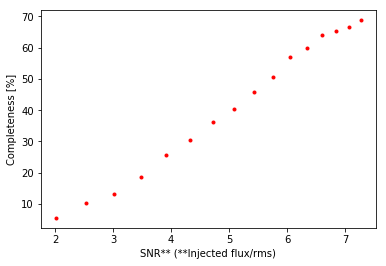

In [17]:
plt.plot(np.array(flux_injected)/np.array(rms), complete, 'r.')
plt.xlabel("SNR** (**Injected flux/rms)")
plt.ylabel("Completeness [%]")

Comments:
- this is the result for 1 PB, of course it will increase the completeness if we only check the inner region, and decrease if we include the outer region (e.g. completeness until 1.5 PB) -> in other notebook

### About Flux (photometry in sextractor)

+ from literature usually people use FLUX_BEST, which can switch between AUTO and ISOCOR (if crowded).
+ AUTO is using Kron radius to calculate flux (count)
+ I still confused of how to scaling the flux because if I look at the aperture used by sextractor to calculate the flux is really not homogen (the shape and size) -> my expectation of the shape and the size is similar to the beam (because it is point source)
+ should I use fixed aperture?

In [18]:
hdu_list = fits.open('./cttest01/check_injected_flux_0.0001224.cont.fits')

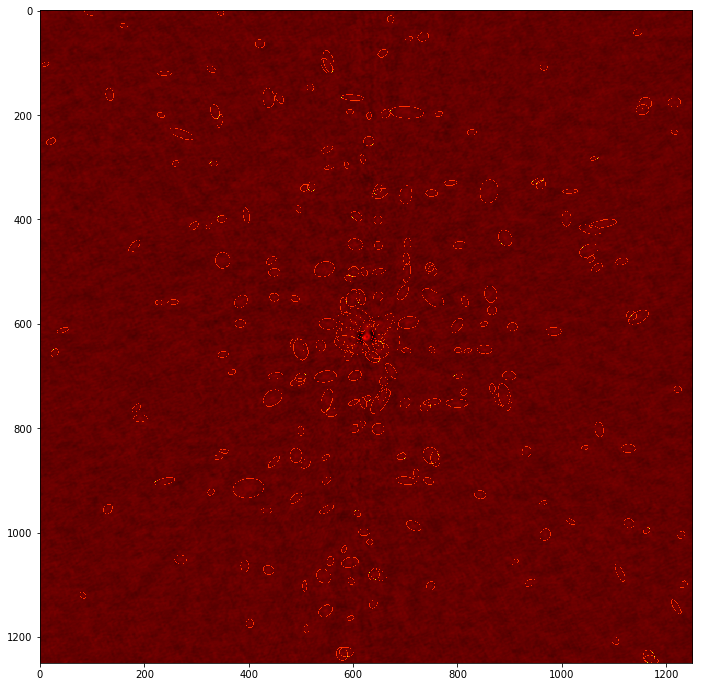

In [19]:
# plot of aperture (generated using sextractor)
plt.figure(figsize=(12,12))
plt.imshow(hdu_list[0].data, cmap='hot')

---

---

**Technical Note**
+ To run a batch of images in sextractor we can use 

    CATALOG_NAME     STDOUT
and make a simple script

+ aperture image can be generated using CHECK IMAGE parameter in config file of sextractor

    CHECKIMAGE_TYPE  APERTURES 